# Homework 1

In [198]:
import pandas as pd
import random
import math

import seaborn as sns
import matplotlib.pyplot as plt

## Load the data

The data is composed by...

In [199]:
df = pd.read_csv('data/applications_of_DM.csv', sep=',')
df

,title,text
0,Anomaly Detection at Multiple Scales,"Anomaly Detection at Multiple Scales, or ADAMS..."
1,Behavioral analytics,Behaviorism is a systematic approach to unders...
2,Business analytics,Business analysis is a professional discipline...
3,CORE (research service),CORE (Connecting Repositories) is a service pr...
4,Daisy Intelligence,Daisy Intelligence is a Canadian Artificial In...
5,Data Applied,Data Applied is a software vendor headquartere...
6,Data mining in agriculture,Data mining in agriculture is a recent researc...
7,Data thinking,"Data thinking is a buzzword for the generic ""m..."
8,Document processing,Document processing is a field of research and...
9,Equifax Workforce Solutions,"Equifax Workforce Solutions, formerly known as..."


## Classes

In [221]:
class Shingling:
    def __init__(self, k):
        self.k = k  # The length of the shingle
        self.N = 2 ** 32 - 1

    def shingle_document(self, document):
        shingles = set()
        for i in range(len(document) - self.k + 1):
            shingle = document[i:i + self.k]
            hash_val = hash(shingle) % self.N
            shingles.add(hash_val)
        return shingles

class CompareSets:
    def jaccard_similarity(set1, set2):
        intersection = set1.intersection(set2)
        union = set1.union(set2)
        return len(intersection) / len(union)

class MinHashing:
    def __init__(self, k, num_shingles):
        self.k = k  # The length of the signature
        self.num_shingles = num_shingles # c
        self.coefficients = [(random.randint(0, num_shingles), random.randint(0, num_shingles)) for _ in range(k)]

    def minhash(self, shingles):
        signature = []
        for a, b in self.coefficients:
            min_hash = min([(a * shingle + b) % self.num_shingles for shingle in shingles])
            signature.append(min_hash)
        return signature

class CompareSignatures:
    def jaccard_similarity(sig1, sig2):
        intersection = 0
        for i in range(len(sig1)):
            if sig1[i] == sig2[i]:
                intersection += 1
        return intersection / len(sig1)

class LSH:
    def __init__(self, b, r, num_shingles):
        self.b = b
        self.r = r
        self.num_shingles = num_shingles
        self.coefficients = (random.randint(0, num_shingles), random.randint(0, num_shingles))
        self.buckets = [{} for _ in range(b)]

    def hash(self, signature):
        hashes = []
        for i in range(self.b):
            a = self.coefficients[0]
            b = self.coefficients[1]
            hash_val = min([(a * signature[i * self.r + j] + b) % self.num_shingles for j in range(self.r)])
            hashes.append(hash_val)
        return hashes

    def query(self, hash1, hash2):
        candidate_pairs = 0
        for i in range(self.b):
            if hash1[i] == hash2[i]:
                candidate_pairs += 1
        return candidate_pairs/self.b


### Dummy example

Let us now test the Shingling with a dummy example. We took $K=3$ because of the shortness of the documents in the example. With increasing k-s the less similar the documents are going to be, since we are anlyzing larger chunks and it is more rare to have similar chunks of that size, while it is easier to have 1-grams, 2-grams in common.

In [201]:
doc1 = "hello world today is a good day to die"
doc2 = "hello world today is a good day to live"
doc3 = "this document is very different from the other two documents"

shingling = Shingling(k=3)
shingles1 = shingling.shingle_document(doc1)
shingles2 = shingling.shingle_document(doc2)
shingles3 = shingling.shingle_document(doc3)

print("Jaccard similarity between doc1 and doc2 is: ", CompareSets.jaccard_similarity(shingles1, shingles2))
print("Jaccard similarity between doc1 and doc3 is: ", CompareSets.jaccard_similarity(shingles1, shingles3))
print("Jaccard similarity between doc2 and doc3 is: ", CompareSets.jaccard_similarity(shingles2, shingles3))

Jaccard similarity between doc1 and doc2 is:  0.8108108108108109
Jaccard similarity between doc1 and doc3 is:  0.05263157894736842
Jaccard similarity between doc2 and doc3 is:  0.02531645569620253


Let us now try with $k=1$. We expect to have higher similarities even if the documents d1-d3 and d2-d3 are completely different.

In [202]:
doc1 = "hello world today is a good day to die"
doc2 = "hello world today is a good day to live"
doc3 = "this document is very different from the other two documents"

shingling = Shingling(k=1)
shingles1 = shingling.shingle_document(doc1)
shingles2 = shingling.shingle_document(doc2)
shingles3 = shingling.shingle_document(doc3)

print("Jaccard similarity between doc1 and doc2 is: ", CompareSets.jaccard_similarity(shingles1, shingles2))
print("Jaccard similarity between doc1 and doc3 is: ", CompareSets.jaccard_similarity(shingles1, shingles3))
print("Jaccard similarity between doc2 and doc3 is: ", CompareSets.jaccard_similarity(shingles2, shingles3))

Jaccard similarity between doc1 and doc2 is:  0.9333333333333333
Jaccard similarity between doc1 and doc3 is:  0.55
Jaccard similarity between doc2 and doc3 is:  0.6


Let us now test the MinHashing class and methods on the same dummy example presented before.

In [203]:
# Get the shingles for each document
shingling = Shingling(k=3)
documents = [doc1, doc2, doc3]

shingles = [shingling.shingle_document(document) for document in documents] # Get the total number of shingles
num_shingles = len(set().union(*shingles)) # This is the c parameter of the hash functions

print("Total number of shingles across all documents", num_shingles)

Total number of shingles across all documents 80


Now, we need to choose k wisely, as random guesses would not end up in good results. $K=1$ is too small and the expected error is too high. Larger k-s are better, as we can potentially reach the original number of shingles (rows of the shingles x documents matrix) and minimize the error. However, the computational cost is too high. We need to find a trade-off between the two. We can try with $K=20\%$ of the document with the highest number of shingles (length of the shingles x documents matrix).

In [204]:
len(shingles3) # The document with the longest shingle set

17

In [205]:
int(len(shingles3) / 100 * 20) # The number of hash functions we need to use

3

In [206]:
min_hashing = MinHashing(k=3, num_shingles=num_shingles)

minhashes1 = min_hashing.minhash(shingles[0])
minhashes2 = min_hashing.minhash(shingles[1])
minhashes3 = min_hashing.minhash(shingles[2])

print("Jaccard similarity between doc1 and doc2 is: ", CompareSignatures.jaccard_similarity(minhashes1, minhashes2))
print("Jaccard similarity between doc1 and doc3 is: ", CompareSignatures.jaccard_similarity(minhashes1, minhashes3))
print("Jaccard similarity between doc2 and doc3 is: ", CompareSignatures.jaccard_similarity(minhashes2, minhashes3))

Jaccard similarity between doc1 and doc2 is:  1.0
Jaccard similarity between doc1 and doc3 is:  0.6666666666666666
Jaccard similarity between doc2 and doc3 is:  0.6666666666666666


### Real data

Let us now run all the classes and methods for the real data.

#### Shinling

In [207]:
# Compute the shingles
shingling = Shingling(k=8) # k=9,10 was suggested on the slides (good for long documents)

shingles_dict = {}

for i, row in df.iterrows():
    shingles_dict[i] = shingling.shingle_document(row['text'])

In [208]:
# Comput Jaccard Similarity with CompareSets
jaccard_similarities = pd.DataFrame(columns=[i for i in range(len(shingles_dict))], index=[i for i in range(len(shingles_dict))])

for i in shingles_dict.keys():
    for j in shingles_dict.keys():
        jaccard_similarities[i][j] = CompareSets.jaccard_similarity(shingles_dict[i], shingles_dict[j])

jaccard_similarities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,0.003361,0.00631,0.009898,0.006944,0.011379,0.010881,0.010227,0.010569,0.007444,0.001785,0.006545,0.007674,0.005114,0.152751,0.008836,0.005083
1,0.003361,1.0,0.050566,0.021845,0.002882,0.003275,0.026998,0.020418,0.022709,0.018881,0.005659,0.006118,0.02144,0.052604,0.006299,0.054089,0.005885
2,0.00631,0.050566,1.0,0.031718,0.002593,0.005345,0.031704,0.036694,0.029366,0.024739,0.005173,0.007512,0.027289,0.050411,0.011793,0.057055,0.007233
3,0.009898,0.021845,0.031718,1.0,0.005341,0.010169,0.027553,0.03487,0.024661,0.023879,0.011819,0.01207,0.020345,0.024488,0.015192,0.038687,0.01226
4,0.006944,0.002882,0.002593,0.005341,1.0,0.017889,0.005879,0.00437,0.005442,0.010229,0.001528,0.005082,0.008396,0.002824,0.010811,0.004877,0.00699
5,0.011379,0.003275,0.005345,0.010169,0.017889,1.0,0.008961,0.018713,0.012132,0.010204,0.010708,0.004739,0.00872,0.003162,0.017535,0.009177,0.007226
6,0.010881,0.026998,0.031704,0.027553,0.005879,0.008961,1.0,0.02565,0.035155,0.01622,0.010735,0.017291,0.024547,0.025984,0.013958,0.035256,0.00923
7,0.010227,0.020418,0.036694,0.03487,0.00437,0.018713,0.02565,1.0,0.026234,0.018402,0.0083,0.016075,0.019191,0.015402,0.01416,0.027848,0.009196
8,0.010569,0.022709,0.029366,0.024661,0.005442,0.012132,0.035155,0.026234,1.0,0.01809,0.009206,0.014875,0.015632,0.023798,0.014351,0.045587,0.005686
9,0.007444,0.018881,0.024739,0.023879,0.010229,0.010204,0.01622,0.018402,0.01809,1.0,0.003878,0.006781,0.011384,0.020973,0.010016,0.026987,0.012019


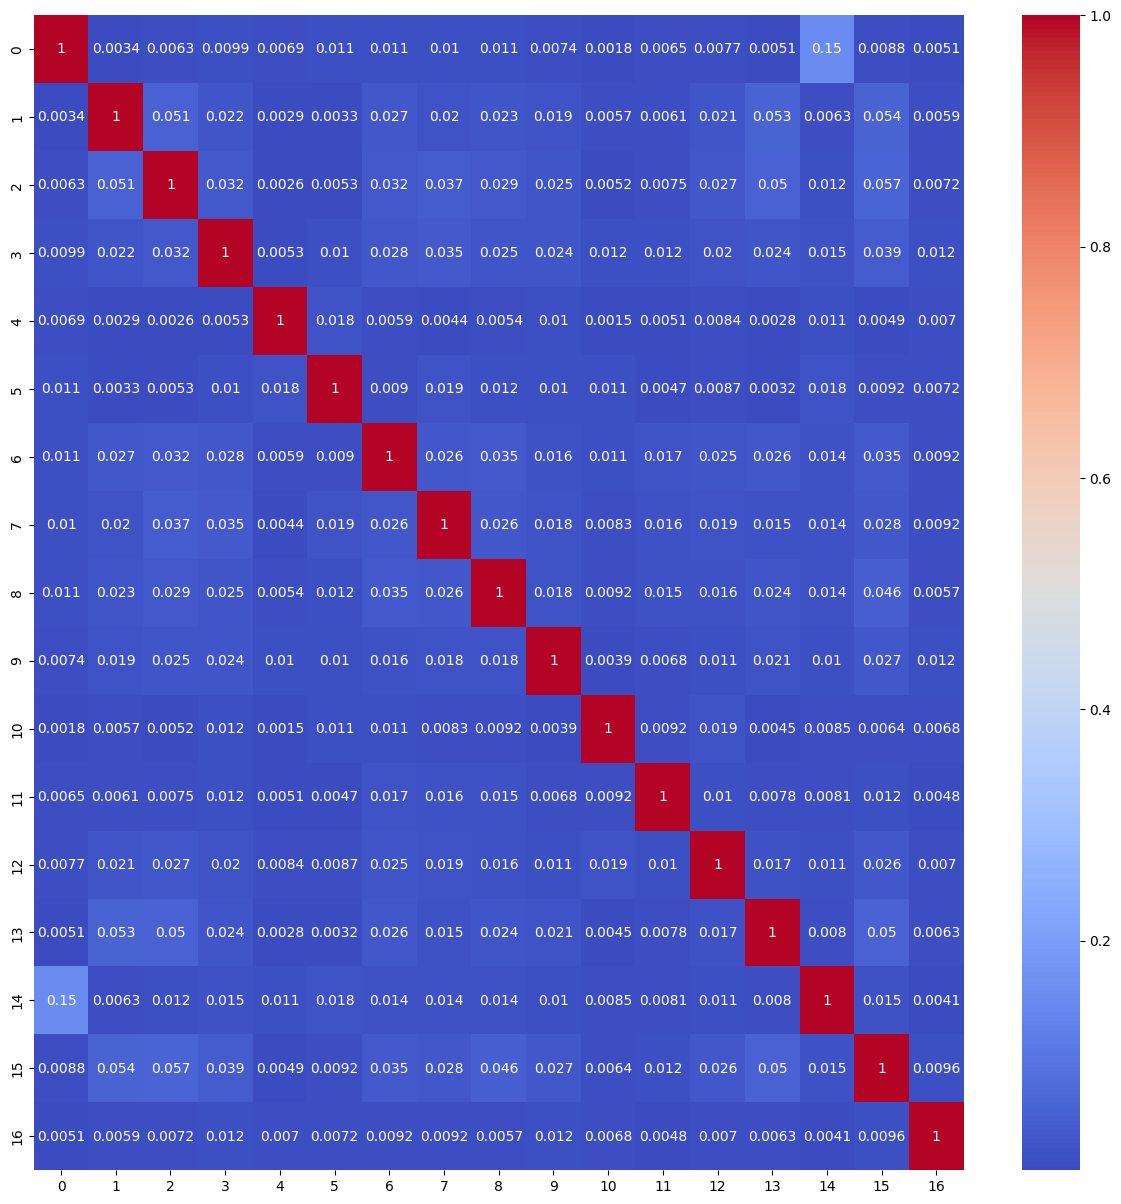

In [209]:
# Heatmap of the Jaccard Similarities
plt.figure(figsize=(15, 15))
sns.heatmap(jaccard_similarities.astype(float), cmap='coolwarm', annot=True)
plt.show()

As we can see from the Heatmap above...

In [210]:
# Add thresholding s to the jaccard similarities
s = 0.1
for i in range(len(shingles_dict)):
    for j in range(i + 1, len(shingles_dict)):
        if jaccard_similarities[i][j] > s:
            print("Document {} and {} have a Jaccard similarity of {}".format(i, j, jaccard_similarities[i][j]))

Document 0 and 14 have a Jaccard similarity of 0.1527514231499051


#### MinHashing

Let us now proceed with the MinHashing class and methods on the real data.

In [211]:
# Get the shingles for each document
shingling = Shingling(k=10)
documents = df["text"]
shingles = [shingling.shingle_document(document) for document in documents] # Get the number of shingles
num_shingles = len(set().union(*shingles))
print("Number of shingles", num_shingles)

Number of shingles 135497


In [212]:
# Find the document with the longest shingle set (lenght of the shingles x documents matrix)
max = 0
for i in range(len(shingles)):
    if len(shingles[i]) > max:
        max = len(shingles[i])

print("The document with the longest shingle set has", max, "shingles")

The document with the longest shingle set has 41536 shingles


In [213]:
# Compute the min hashes
k = int(max/100*20)
print("We will use", k, "hash functions")
min_hashing = MinHashing(k=1000, num_shingles=num_shingles) # Take k as 20% of the longest shingle set

min_hashes = []

for shingle in shingles:
    min_hashes.append(min_hashing.minhash(shingle))

We will use 8307 hash functions


In [214]:
# Compute Jaccard Similarity with CompareSignatures
jaccard_similarities_min_hashing = pd.DataFrame(columns=[i for i in range(len(shingles_dict))], index=[i for i in range(len(shingles_dict))])

for i in range(len(min_hashes)):
    for j in range(len(min_hashes)):
        jaccard_similarities_min_hashing[i][j] = CompareSignatures.jaccard_similarity(min_hashes[i], min_hashes[j])

jaccard_similarities_min_hashing

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,0.004,0.008,0.007,0.004,0.006,0.008,0.009,0.014,0.006,0.008,0.008,0.006,0.004,0.123,0.013,0.001
1,0.004,1.0,0.106,0.042,0.009,0.003,0.042,0.024,0.024,0.046,0.004,0.006,0.033,0.143,0.01,0.094,0.018
2,0.008,0.106,1.0,0.042,0.003,0.007,0.045,0.036,0.034,0.044,0.01,0.011,0.031,0.111,0.016,0.09,0.015
3,0.007,0.042,0.042,1.0,0.005,0.009,0.033,0.028,0.021,0.025,0.011,0.017,0.024,0.045,0.018,0.043,0.013
4,0.004,0.009,0.003,0.005,1.0,0.009,0.004,0.004,0.005,0.007,0.004,0.008,0.009,0.006,0.006,0.004,0.003
5,0.006,0.003,0.007,0.009,0.009,1.0,0.007,0.01,0.006,0.007,0.005,0.005,0.005,0.005,0.007,0.003,0.003
6,0.008,0.042,0.045,0.033,0.004,0.007,1.0,0.027,0.034,0.03,0.011,0.01,0.027,0.04,0.019,0.05,0.019
7,0.009,0.024,0.036,0.028,0.004,0.01,0.027,1.0,0.024,0.02,0.013,0.015,0.015,0.02,0.01,0.03,0.008
8,0.014,0.024,0.034,0.021,0.005,0.006,0.034,0.024,1.0,0.016,0.005,0.014,0.017,0.043,0.019,0.047,0.012
9,0.006,0.046,0.044,0.025,0.007,0.007,0.03,0.02,0.016,1.0,0.007,0.011,0.026,0.042,0.007,0.036,0.015


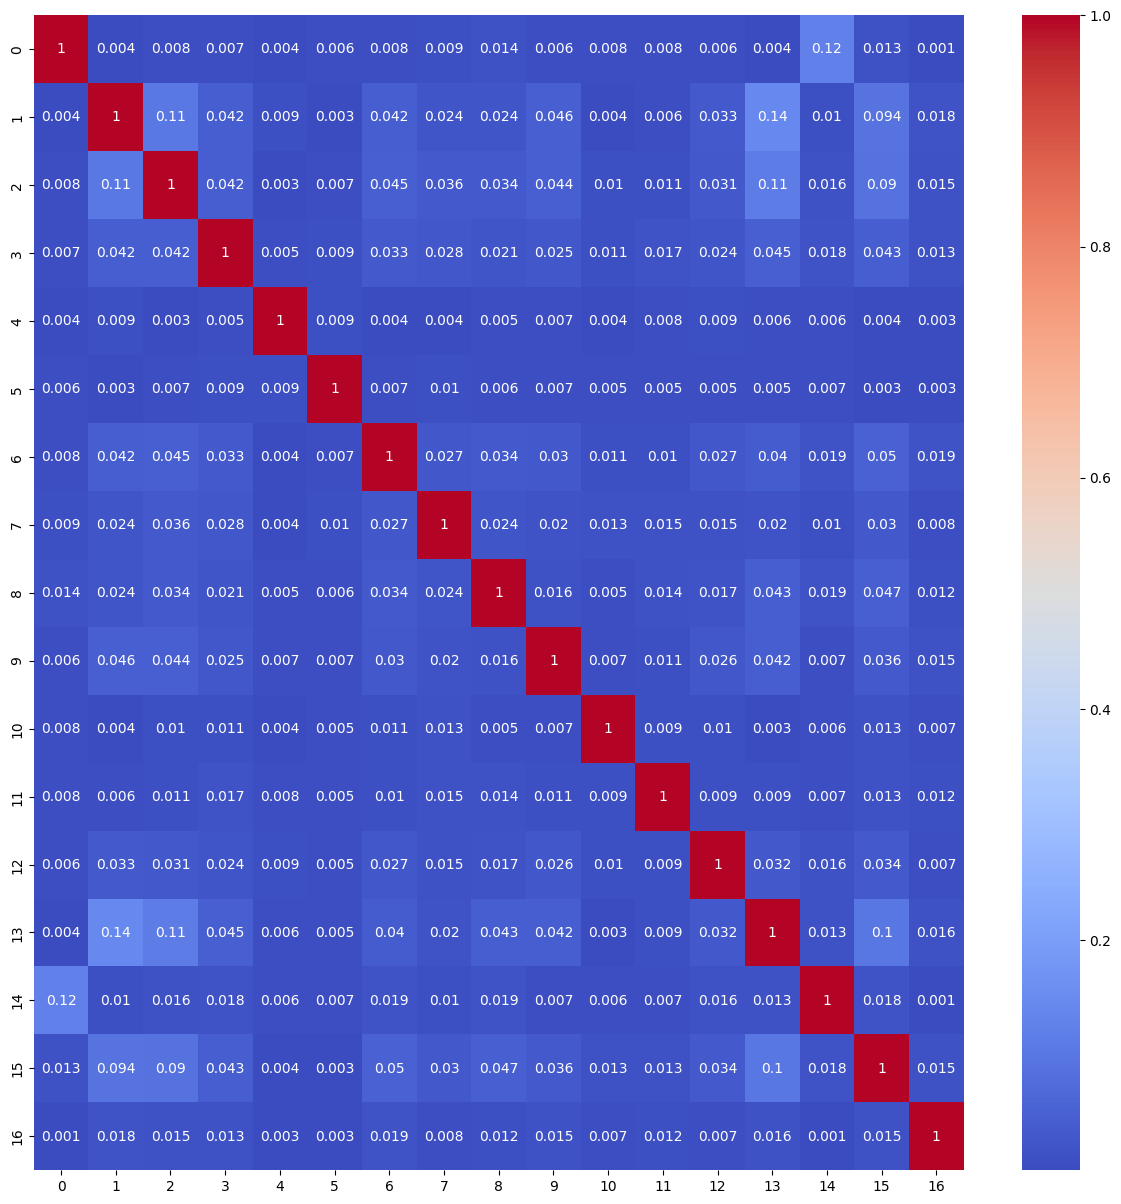

In [215]:
# Heatmap of the Jaccard Similarities with Min Hashing
plt.figure(figsize=(15, 15))
sns.heatmap(jaccard_similarities_min_hashing.astype(float), cmap='coolwarm', annot=True)
plt.show()

As we can see from the Heatmap above...

In [216]:
# Add thresholding s to the jaccard similarities
s = 0.1
for i in range(len(shingles_dict)):
    for j in range(i + 1, len(shingles_dict)):
        if jaccard_similarities_min_hashing[i][j] > s:
            print("Document {} and {} have a Jaccard similarity of {}".format(i, j, jaccard_similarities_min_hashing[i][j]))

Document 0 and 14 have a Jaccard similarity of 0.123
Document 1 and 2 have a Jaccard similarity of 0.106
Document 1 and 13 have a Jaccard similarity of 0.143
Document 2 and 13 have a Jaccard similarity of 0.111
Document 13 and 15 have a Jaccard similarity of 0.102


#### LSH

Let us finish by implementing the LSH technique.

pick b and r to satisfy the equation b*r = k and (1/b)^(1/r) = s

In [217]:
b = 50 # Number of bands
r = 20 # Number of rows per band

In [222]:
# Compute LSH
lsh = LSH(b=b, r=r, num_shingles=num_shingles)

lsh_hashes = []

for min_hash in min_hashes:
    lsh_hashes.append(lsh.hash(min_hash))

# Compute Jaccard Similarity with LSH
jaccard_similarities_lsh = pd.DataFrame(columns=[i for i in range(len(shingles_dict))], index=[i for i in range(len(shingles_dict))])

for i in range(len(lsh_hashes)):
    for j in range(len(lsh_hashes)):
        jaccard_similarities_lsh[i][j] = lsh.query(lsh_hashes[i], lsh_hashes[j])

jaccard_similarities_lsh

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,0.02,0.02,0.08,0.02,0.02,0.08,0.06,0.0,0.0,0.04,0.04,0.06,0.02,0.08,0.04,0.04
1,0.02,1.0,0.26,0.08,0.06,0.02,0.26,0.12,0.1,0.14,0.02,0.02,0.12,0.3,0.04,0.18,0.04
2,0.02,0.26,1.0,0.2,0.0,0.02,0.12,0.3,0.16,0.24,0.02,0.02,0.24,0.28,0.1,0.32,0.12
3,0.08,0.08,0.2,1.0,0.02,0.0,0.2,0.2,0.08,0.2,0.0,0.1,0.16,0.12,0.06,0.16,0.16
4,0.02,0.06,0.0,0.02,1.0,0.04,0.02,0.02,0.06,0.04,0.06,0.02,0.02,0.04,0.0,0.02,0.04
5,0.02,0.02,0.02,0.0,0.04,1.0,0.04,0.02,0.04,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
6,0.08,0.26,0.12,0.2,0.02,0.04,1.0,0.2,0.16,0.28,0.06,0.08,0.16,0.1,0.08,0.2,0.08
7,0.06,0.12,0.3,0.2,0.02,0.02,0.2,1.0,0.1,0.12,0.1,0.14,0.22,0.12,0.1,0.14,0.12
8,0.0,0.1,0.16,0.08,0.06,0.04,0.16,0.1,1.0,0.12,0.04,0.08,0.14,0.06,0.08,0.14,0.12
9,0.0,0.14,0.24,0.2,0.04,0.02,0.28,0.12,0.12,1.0,0.02,0.02,0.22,0.14,0.08,0.18,0.1


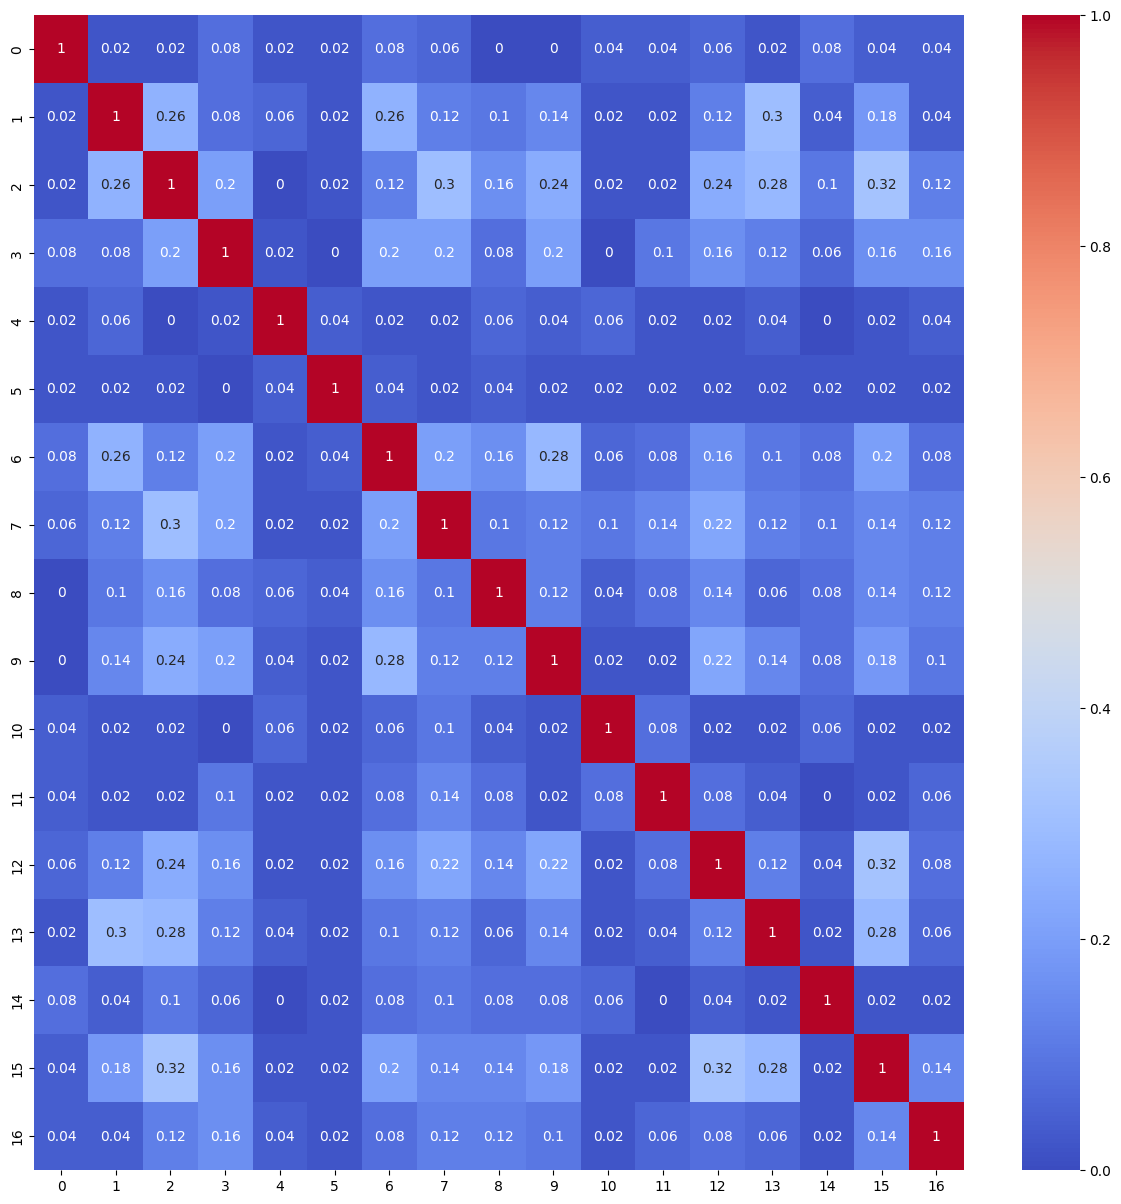

In [223]:
# Heatmap of the Jaccard Similarities with LSH
plt.figure(figsize=(15, 15))
sns.heatmap(jaccard_similarities_lsh.astype(float), cmap='coolwarm', annot=True)
plt.show()

In [226]:
# Add thresholding t to the jaccard similarities
t = 0.28 # Threshold
for i in range(len(shingles_dict)):
    for j in range(i + 1, len(shingles_dict)):
        if jaccard_similarities_lsh[i][j] > t:
            print("Document {} and {} have a Jaccard similarity of {}".format(i, j, jaccard_similarities_lsh[i][j]))

Document 1 and 13 have a Jaccard similarity of 0.3
Document 2 and 7 have a Jaccard similarity of 0.3
Document 2 and 15 have a Jaccard similarity of 0.32
Document 12 and 15 have a Jaccard similarity of 0.32


## Conclusions

As we can notice from the results above the LSH returns higher values for the similarity. That is because LSH does not concentrate the single values od the signature matrix, but it groups them in buckets. This means that the similarity is not a single value, but it is a range of values. Therefore, two documents could end up in the same bucket even if they do not have all the values in common in that band. This is the reason why the similarity is higher, since then the Jaccard is computed on the number of buckets in common out of the total number of buckets (=number of bands).

Let us show it with and example. Let us consider the following signature matrix (after minhashing):

In [231]:
d1 = [1, 3, 7, 9]
d2 = [1, 4, 8, 10]

df = pd.DataFrame(columns=['d1', 'd2'])
df['d1'] = d1
df['d2'] = d2
df

,d1,d2
0,1,1
1,3,4
2,7,8
3,9,10


If we compute the Jaccard similarity between the first two columns, using CompareSignatures, we get:
$ \frac{1}{4} = 0.25 $.
If we run LSH with b=2 and r=2, we could get the following new signature matrix:

In [232]:
d1 = [1, 2]
d2 = [1, 2]

df = pd.DataFrame(columns=['d1', 'd2'])
df['d1'] = d1
df['d2'] = d2
df

,d1,d2
0,1,1
1,2,2


And the Jaccard similarity between the first two columns is now:
$ \frac{1}{2} = 0.5 $.
This shows that the similarity is higher, since the two documents are in the same bucket, even if they do not have all the values in common in that band.